In [1]:
!pip install speechbrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.1/408.1 KB 5.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 11.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 MB 13.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 KB 2.7 MB/s eta 0:00:00
  Using cached sentencepiece-0.1.96-cp38-cp38-macosx_11_0_arm64.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 KB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 KB 3.8 MB/s eta 0:00:00
  Using cached ruamel.yaml.clib-0.2.6-cp38-cp38-macosx_11_0_arm64.whl
  Created wheel for pyyaml: filename=PyYAML-6.0-cp38-cp38-macosx_11_0_arm64.whl size=45337 sha256=d83a3524df5e58c3dd874701894ad063c8989

In [16]:
import os
import glob
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
from math import floor
import matplotlib.pyplot as plt

from lib_utility import cos_sim

In [3]:
data_path = './sound'
json_list = glob.glob(os.path.join(data_path, '*.json'))

In [11]:
speaker_simi_thre = 0.4

In [4]:
json_list

['./sound/this-american-life_getting-out.json',
 './sound/npr-politics_school-mask-ban.json',
 './sound/conan-obrien_cecily-strong.json',
 './sound/99-invisible_matters-of-time.json',
 './sound/npr-politics_cutting-unemployment.json',
 './sound/radiolab_dark-side-of-the-earth.json',
 './sound/masters-of-scale_build-the-right-flywheel.json',
 './sound/my-first-million_the-secret-to-being-great.json',
 './sound/the-internet-says-its-true_hollywood.json',
 './sound/npr-politics_august-27th.json',
 './sound/a16z_developers-as-creatives.json',
 './sound/the-internet-says-its-true_hidden-village.json',
 './sound/this-american-life_essential.json',
 './sound/conan-obrien_joel-mchale.json',
 './sound/my-first-million_how-to-build-a-community.json',
 './sound/99-invisible_stuff-the-british-stole.json',
 './sound/masters-of-scale_make-it-epic.json',
 './sound/radiolab_dinopocalypse-redux.json',
 './sound/a16z_malaria-vaccine.json',
 './sound/a16z_crypto.json',
 './sound/masters-of-scale_master-y

In [5]:
pd.set_option('display.max_rows', None)

In [6]:
import torchaudio
from speechbrain.pretrained import EncoderClassifier

classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb")

Downloading:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/129k [00:00<?, ?B/s]

In [26]:
for j in [json_list[-2]]:
# for j in json_list[0:2]:
# for j in json_list:
    j_curr = os.path.basename(j)
    sound_curr0 = j_curr[:-4]+'wav'
    print(sound_curr0)
    sound_curr = os.path.join(data_path, sound_curr0)

    if not os.path.exists(sound_curr):
        print('{0} does not exist.'.format(sound_curr0))
        break

    samples, fs = torchaudio.load(sound_curr)
    # embeddings = classifier.encode_batch(signal)
    
    # Read sentences from json files
    sentence_list = []
    text = json.load(open(os.path.join(data_path, j_curr)))
    data = text['results']['items']
    df = pd.json_normalize(data, record_path =['alternatives'], meta=['start_time', 'end_time', 'type'], errors='ignore')  
    # a datafram that contains a word in each row

    # calculate the speaker embedding
    segment_id = 0    
    start_time = -1.0
    end_time = -1.0
    segment_id_list = []
    id_embedding = []
    # for i, row in df.iterrows():
    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        # print(row)
        if (row['content'] == '.') | ((row['content'] == '?'))| ((row['content'] == '?')):
            # print(f'Segment {segment_id}')

            # samples_np = samples.numpy().reshape((-1))
            # samples_curr = samples_np[int(floor(start_time*fs)): int(floor(end_time*fs))]
            samples_curr = samples[0, int(floor(start_time*fs)): int(floor(end_time*fs))]
            embeddings = classifier.encode_batch(samples_curr)
            embeddings_np = embeddings.numpy().reshape((-1))
            # id_embedding.update({segment_id: embeddings_np})
            id_embedding.append(embeddings_np)
            segment_id_list.append(segment_id)
            start_time = -1.0            
            segment_id += 1
        elif row['type'] != 'punctuation':
            if start_time == -1.0:
                start_time = floor(row['start_time'])
            start_time = min(start_time, row['start_time'])
            end_time = max(end_time, row['end_time'])
            segment_id_list.append(segment_id)
        else: # other punctuation
            segment_id_list.append(segment_id)
            
    # Add segment id / sentence id
    df['segment_id'] = segment_id_list
    
    # Calcuate the embedding similarity between two adjacent segments
    speaker_list = []
    for i in range(len(id_embedding)-1):
        speaker_list.append(cos_sim(id_embedding[i], id_embedding[i+1]))
    speaker_score = np.array(speaker_list)
    
    # segment mapping from sentences to speakers
    num_sentence_changes = speaker_score.shape[0]
    speaker_id = np.zeros((num_sentence_changes+1)).astype(int)
    speaker_segment = 0
    speaker_id[0] = speaker_segment
    for i in range(num_sentence_changes):
        if speaker_score[i] < speaker_simi_thre:
            speaker_segment += 1
        speaker_id[i+1] = speaker_segment

    # write speaker id
    human_segment_id = []
    for i, row in df.iterrows():
        if row['segment_id'] >= speaker_id.shape[0]:
            human_segment_id.append(speaker_segment)
        else:
            human_segment_id.append(speaker_id[row['segment_id']])
    df['human_segment_id'] = human_segment_id
    
    df.to_csv(os.path.join('./sound', j_curr[:-4]+'csv'))

a16z_crypto.wav


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7801/7801 [00:28<00:00, 272.58it/s]


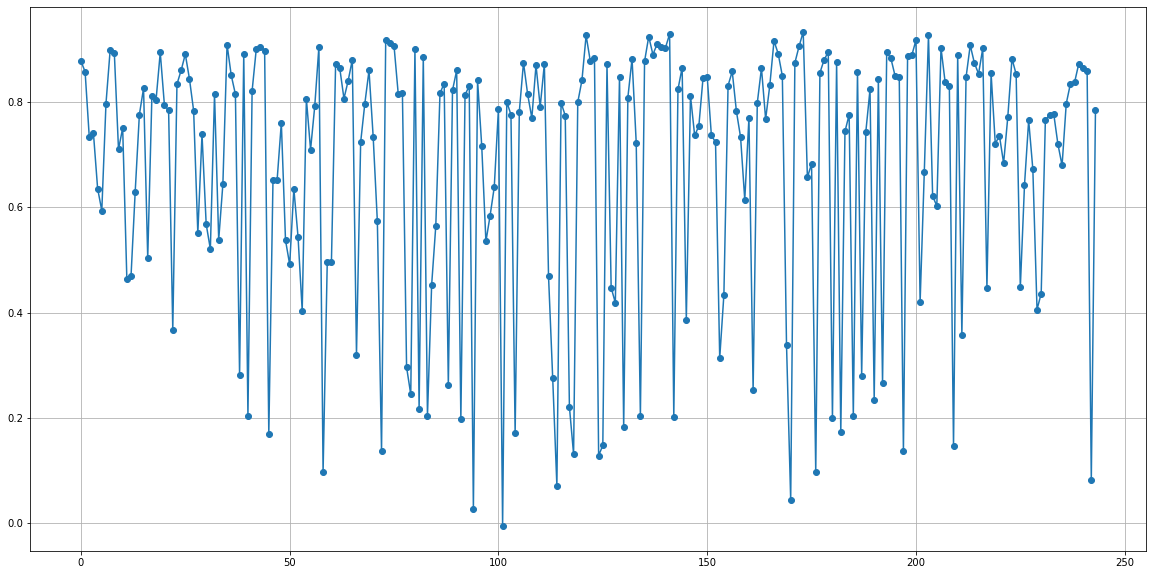

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(speaker_score, '-o')
ax.grid()

In [31]:
df

,confidence,content,start_time,end_time,type,segment_id,human_segment_id
0,1.0,Welcome,0.0,0.4,pronunciation,0,0
1,1.0,to,0.4,0.48,pronunciation,0,0
2,1.0,the,0.48,0.56,pronunciation,0,0
3,1.0,sixteen,0.64,1.12,pronunciation,0,0
4,1.0,seed,1.28,1.52,pronunciation,0,0
5,1.0,podcast,1.6,2.0,pronunciation,0,0
6,1.0,Zorn,2.24,2.72,pronunciation,0,0
7,1.0,today,2.88,2.96,pronunciation,0,0
8,1.0,we,3.04,3.12,pronunciation,0,0
9,1.0,have,3.2,3.28,pronunciation,0,0


In [22]:
speaker_segment

41

In [13]:
j_curr[:-4]+'csv'

'a16z_crypto.csv'

In [20]:
# Add segment id / sentence id
df['segment_id'] = segment_id_list

# Calcuate the embedding similarity between two adjacent segments
speaker_list = []
for i in range(len(id_embedding)-1):
    speaker_list.append(cos_sim(id_embedding[i], id_embedding[i+1]))
speaker_score = np.array(speaker_list)

# segment mapping from sentences to speakers
num_sentence_changes = speaker_score.shape[0]
speaker_id = np.zeros((num_sentence_changes+1)).astype(int)
speaker_segment = 0
speaker_id[0] = speaker_segment
for i in range(num_sentence_changes):
    if speaker_score[i] < speaker_simi_thre:
        speaker_segment += 1
    speaker_id[i+1] = speaker_segment

# write speaker id
human_segment_id = []
for i, row in df.iterrows():
    if row['segment_id'] >= speaker_id.shape[0]:
        human_segment_id.append(num_sentence_changes)
    else:
        human_segment_id.append(speaker_id[row['segment_id']])
df['human_segment_id'] = human_segment_id

df.to_csv(os.path.join('./sound', j_curr[:-4]+'csv'))
